# Validating the numerical Z

In [33]:
import sys
sys.path.append("../numerical_z")
sys.path.append("../fart/")
import numerical_z
from numerical_z.numerical_z import NumericZ
from numerical_z.plasma import PlasmaParameters
from numerical_z.ecdi import eps_ECDI
from numerical_z.evdfs import generalized_Maxw_f, maxw_f
from fart import solver_tree

from functools import partial
from importlib import reload

reload(numerical_z)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("presentation")
from plasmapy.mathematics import plasma_dispersion_func

import numpy as np


In [34]:
"""plasma parameters"""
prt = PlasmaParameters()
"External parameters"
domain = (0.0, -0.1, 0.5, 0.1)
kx=0.01
ky = 0.1
kz=0.0

In [35]:
Znum =  NumericZ(partial(maxw_f, vt = 1), N=64)


/home/tavant/bin/MyVenv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tavant/bin/MyVenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


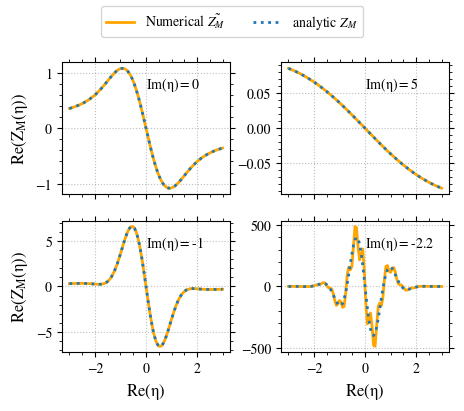

In [36]:
w_rs = np.linspace(-3,3,100)


fig, axarr = plt.subplots(2,2, figsize=(5,4))
ax1, ax2, ax3, ax4 = axarr.ravel()

for ax, w_i in zip(axarr.ravel(), [0, 5, -1, -2.2]):
    w = w_rs + 1.j*w_i

    line1, = ax.plot(w, np.real(Znum(w)), "orange", label="Numerical")
    line2, = ax.plot(w, np.real(plasma_dispersion_func(w)), ":", label="analytic")
    ax.annotate("$\\rm{Im} (\\eta) = $"+str(w_i), (0.5,0.8), xycoords="axes fraction")
    
for ax in [ax1, ax3]:
    ax.set_ylabel("$\\rm{Re} (Z_M(\eta))$")
    
for ax in [ax4, ax3]:
    ax.set_xlabel("$\\rm{Re} (\\eta)$")
    
for ax in [ax1, ax2]:
    ax.set_xticklabels([])
    
#ax = plt.subplot2grid((3, 3), (0, 0), colspan=3, fig=fig, )
#ax.legend( [line1, line2], ["Numerical $\\tilde{Z_M}$", "analytic $Z_M$"],  bbox_to_anchor=(0.5,1,1,0.2), ncol=2)
plt.subplots_adjust(top=0.85, wspace=0.3)

plt.figlegend([line1, line2], ["Numerical $\\tilde{Z_M}$", "analytic $Z_M$"], ncol=2, loc='upper center',)
plt.savefig("Validation_numericalZ.pdf")

/home/tavant/bin/MyVenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/tavant/bin/MyVenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


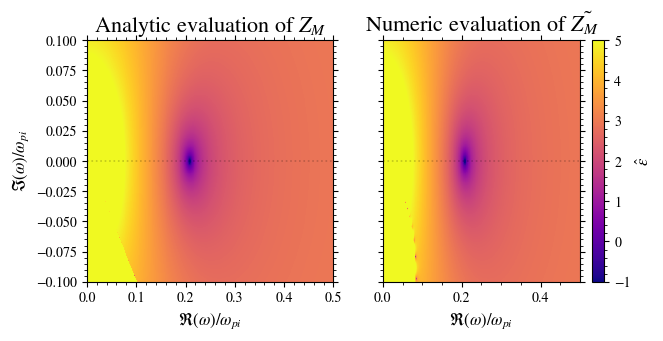

In [37]:
ww = solver_tree.grid(domain, 512)
vmin = -1
vmax = 5
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.2))


values = eps_ECDI(ww, kx, ky, kz)
im1 = ax1.pcolormesh(ww.real, ww.imag, np.log(np.abs(values)), vmin = vmin, vmax = vmax)

values = eps_ECDI(ww.flatten(), kx, ky, kz, Zlocal=Znum).reshape(ww.shape)
im2 = ax2.pcolormesh(ww.real, ww.imag, np.log(np.abs(values)), vmin = vmin, vmax = vmax)



ax1.set_title("Analytic evaluation of ${Z_M}$")
ax2.set_title("Numeric evaluation of $\\tilde{Z_M}$")

cb = fig.colorbar(im2, ax=ax2, orientation='vertical')
cb.ax.set_ylabel("$\\hat{\\epsilon}$",)

ax1.set_ylabel("$\\Im(\omega)/\\omega_{pi}$")
for ax in [ax1, ax2]:
    ax.set_xlabel("$\\Re(\omega)/\\omega_{pi}$")
    ax.hlines(0, 0,0.5, linestyle=":", alpha=0.2, linewidth=1.2)
    ax.set_xlim(left=0)
    

ax2.set_yticklabels([])
plt.savefig("Validation_numericalZ_bis.png", dpi=400)

# IAW general

In [38]:
import directsolver
reload(directsolver)

from numerical_z.plasma import PlasmaParameters
from numerical_z.iaw import eps_IAW, analytic_IAW, analytic_IAW_simple
from numerical_z.langmuir import langmuir_analytic
from directsolver import solvekys

In [39]:
def maxwe(v):
    """Be carefull, the EVDF need to be normiliased"""
    return np.exp(- (v**2)**(1))/np.sqrt(np.pi) #/1.0076194774978673

Znum =  NumericZ(maxwe, N=64)

Anal :$$  \sqrt{ \frac{1}{1 + 1/k^2  }  (1 + 3 T_i (1 + k^2))}  $$

anal simple: $$  \sqrt{ \frac{1}{1 + 1/k^2  }  }  $$

/home/tavant/bin/MyVenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


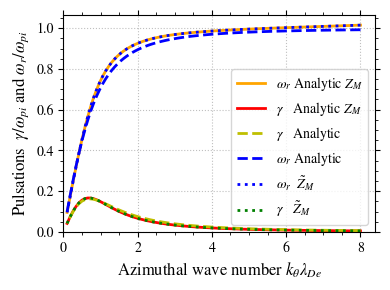

In [44]:
# Compute
kx = 0.0
kz = 0.0
prt=PlasmaParameters(ti = 0.01, te=50)

plasmaEps = partial(eps_IAW, Ze=plasma_dispersion_func, prt=prt)

wrfunct = lambda k: analytic_IAW(k, ti=prt.ti/ prt.te)

kysref, xsref = solvekys(plasmaEps, kx=kx, kz=kz, kymin=8, kymax=0.1, parall=False, wrfunct=wrfunct, method="lm")

#plasmaEps = partial(eps_IAW, Ze=Znummax, Zi=Znumi, prt=prt)
plasmaEps = partial(eps_IAW, Ze=Znum, prt=prt)
kysPIC, xsPIC = solvekys(plasmaEps, kx=kx, kz=kz, kymin=8, kymax=0.1, parall=False, wrfunct=wrfunct, method="lm")


# plot
fig = plt.figure(figsize=(4,3))
plt.plot(kysref, xsref[:,0], "orange", label="$\omega_r$ Analytic $Z_M$")
plt.plot(kysref, xsref[:,1], "red", label="$\gamma$   Analytic $Z_M$")

plt.plot(kysref, prt.vde* np.sqrt(me/mi)*np.sqrt(np.pi/8)*kysref/(1 + kysref**2)**(3/2), "y--", label="$\gamma$   Analytic")
plt.plot(kysref, analytic_IAW_simple(kysref), "b--", label="$\omega_r$ Analytic")

plt.plot(kysPIC, xsPIC[:,0], "b:", label="$\omega_r$  $\\tilde{Z}_M$")
plt.plot(kysPIC, xsPIC[:,1], "g:", label="$\gamma$   $\\tilde{Z}_M$")




plt.legend()
plt.xlabel("Azimuthal wave number $k_{\\theta} \\lambda_{De}$")
plt.ylabel("Pulsations  $\\gamma/\\omega_{pi}$ and $ \\omega_r/\\omega_{pi} $")
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()
plt.savefig("IAW_Maxw.pdf")

In [41]:
from astropy.constants import m_e, m_p
me = m_e.value
mi = m_p.value * 131

In [8]:
prt.vde * prt.cs

1999999.9999999998

## Non Maxwellian


In [45]:
def druv(v, a=1, b=1):
    """Be carefull, the EVDF need to be normiliased"""
    return np.exp(- a*(v**2)**(3/2))/np.sqrt(np.pi) /b

def maxwcuted(v, v_cut=5):
    """Be carefull, the EVDF need to be normiliased"""
    f = np.zeros_like(v)
    mask1 =  v < v_cut
    mask2 =  v >= v_cut
    
    f[mask1] = np.exp(- (v[mask1]**2))
    f[mask2] = 0 # np.exp(- 2*(v[mask2]**2)) * np.exp(-1)/np.exp(-2)
    
    return f   /np.sqrt(np.pi) 

def druv1(v, alpha=0.82, betta=1):
    """Be carefull, the EVDF need to be normiliased"""
    return np.exp(- alpha*(v**2)**(2.5/2))/np.sqrt(np.pi)/1.0784156988002433

v_vect = np.linspace(-10,10,5000)
f = druv(v_vect)
fm = maxwe(v_vect)

print(np.trapz(f*v_vect**2, v_vect)*2)
print(np.trapz(fm*v_vect**2, v_vect)*2)
print(np.trapz(f, v_vect))


0.7522527780636752
1.0000000000000002
1.0076194774999752


In [46]:
from scipy.optimize import minimize


In [47]:
def cost(args):
    a, b =args
    v_vect = np.linspace(-10,10,5000)
    f = druv(v_vect, a, b)
    
    return np.abs(np.trapz(f*v_vect**2, v_vect)*2 -1 ) + np.abs(np.trapz(f, v_vect) -1 ) 

(0, 5)

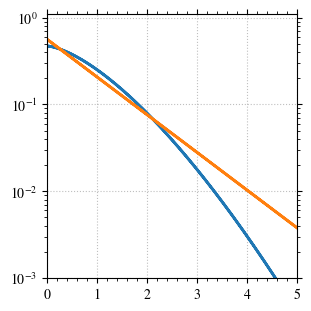

In [48]:
sol = minimize(cost, x0=[1,1] )
a, b = sol.x

plt.figure(figsize=(3,3))

f = druv(v_vect, a,b)

plt.plot(v_vect**2, f)
plt.plot(v_vect**2, fm)
plt.yscale("log")
plt.ylim(bottom=1e-3, top=1.1)
plt.xlim(left=0, right=5)


In [49]:
Znum =  NumericZ(lambda v: druv(v, a, b), N=8) # Druv
#Znum =  NumericZ(maxwcuted, N=8) # Druv


/home/tavant/bin/MyVenv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


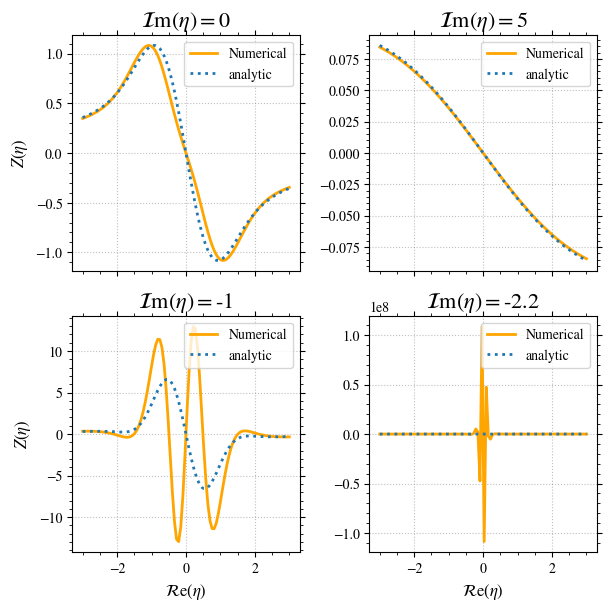

In [50]:
# testing the Z
w_rs = np.linspace(-3,3,100)

fig, axarr = plt.subplots(2,2, figsize=(6,6))
ax1, ax2, ax3, ax4 = axarr.ravel()

for ax, w_i in zip(axarr.ravel(), [0, 5, -1, -2.2]):
    w = w_rs + 1.j*w_i

    ax.plot(w, Znum(w), "orange", label="Numerical")
    ax.plot(w, plasma_dispersion_func(w), ":", label="analytic")
    ax.legend()
    ax.set_title("$\\mathcal{Im}(\\eta) = $"+str(w_i))
    
for ax in [ax1, ax3]:
    ax.set_ylabel("$Z(\eta)$")
    
for ax in [ax4, ax3]:
    ax.set_xlabel("$\\mathcal{Re}(\\eta)$")
    
for ax in [ax1, ax2]:
    ax.set_xticklabels([])
    
# plt.savefig("Validation_numericalZ.pdf")

<IPython.core.display.Javascript object>


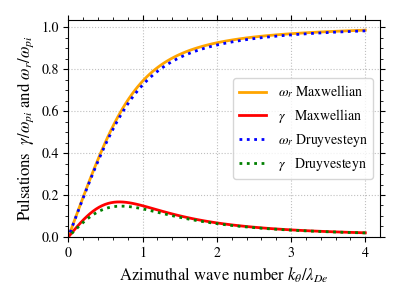

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


In [507]:
# Compute
kx = 0.0
kz = 0.0
prt=PlasmaParameters(ti = 0.01, te=50)

plasmaEps = partial(eps_IAW, Ze=plasma_dispersion_func, prt=prt)

wrfunct = lambda k: analytic_IAW(k, ti=prt.ti/ prt.te)

kysref, xsref = solvekys(plasmaEps, kx=kx, kz=kz, kymin=4, kymax=0.01, parall=False, wrfunct=wrfunct, method="lm")

#plasmaEps = partial(eps_IAW, Ze=Znummax, Zi=Znumi, prt=prt)
Znum =  NumericZ(lambda v: druv(v, a, b), N=64) # Druv

plasmaEps = partial(eps_IAW, Ze=Znum, prt=prt)
kysPIC, xsPIC = solvekys(plasmaEps, kx=kx, kz=kz, kymin=4, kymax=0.01, parall=False, wrfunct=wrfunct, method="lm")


# plot
fig = plt.figure(figsize=(4,3))
plt.plot(kysref, xsref[:,0], "orange", label="$\omega_r$ Maxwellian")
plt.plot(kysref, xsref[:,1], "red", label="$\gamma$   Maxwellian")

plt.plot(kysPIC, xsPIC[:,0], "b:", label="$\omega_r$ Druyvesteyn")
plt.plot(kysPIC, xsPIC[:,1], "g:", label="$\gamma$   Druyvesteyn")


plt.legend()
plt.xlabel("Azimuthal wave number $k_{\\theta}/\\lambda_{De}$")
plt.ylabel("Pulsations  $\\gamma/\\omega_{pi}$ and $ \\omega_r/\\omega_{pi} $")
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()
plt.savefig("IAW_druv.pdf")

<IPython.core.display.Javascript object>


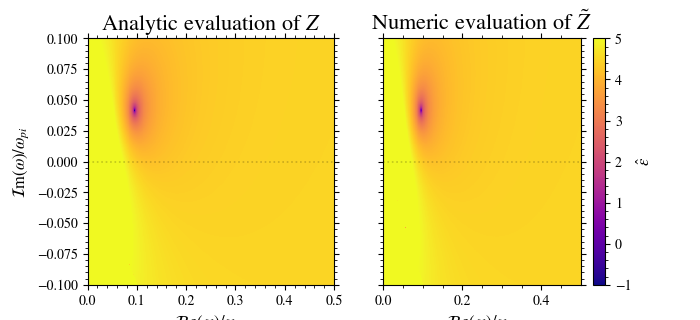

[]

In [448]:
ww = solver_tree.grid(domain, 512)
vmin = -1
vmax = 5
f, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.2))


values = eps_IAW(ww, kx, ky, kz)
im1 = ax1.pcolormesh(ww.real, ww.imag, np.log(np.abs(values)), vmin = vmin, vmax = vmax)

plasmaEps = partial(eps_IAW, Ze=Znum, prt=prt)

values = plasmaEps(ww.flatten(), kx, ky, kz).reshape(ww.shape)
im2 = ax2.pcolormesh(ww.real, ww.imag, np.log(np.abs(values)), vmin = vmin, vmax = vmax)

ax1.set_title("Analytic evaluation of ${Z}$")
ax2.set_title("Numeric evaluation of $\\tilde{Z}$")

cb = fig.colorbar(im2, ax=ax2, orientation='vertical')
cb.ax.set_ylabel("$\\hat{\\epsilon}$",)

ax1.set_ylabel("$\\mathcal{Im}(\omega)/\\omega_{pi}$")
for ax in [ax1, ax2]:
    ax.set_xlabel("$\\mathcal{Re}(\omega)/\\omega_{pi}$")
    ax.hlines(0, 0,0.5, linestyle=":", alpha=0.2, linewidth=1.2)
    ax.set_xlim(left=0)
    

ax2.set_yticklabels([])
# plt.savefig("Validation_numericalZ_bis.png")

## ECDI

In [23]:
def nonM(v):
    return np.exp(- (v**2)**(5/2))/np.sqrt(np.pi)/1.036042480802176

In [24]:
Znum =  NumericZ(nonM, N=128) # Druv

In [25]:
# Compute
kx = 0.05
kz = 0.0
prt=PlasmaParameters(ti = 0.1, te=50)

plasmaEps = partial(eps_ECDI, Zlocal=plasma_dispersion_func, prt=prt, Nmax = 20)

wrfunct = lambda k: analytic_IAW(k, ti=prt.ti/ prt.te)

kysref, xsref = solvekys(plasmaEps, kx=kx, kz=kz, kymin=3, kymax=0.1, wrfunct=wrfunct, method="lm")

#plasmaEps = partial(eps_IAW, Ze=Znummax, Zi=Znumi, prt=prt)
plasmaEpsnm = partial(eps_ECDI, Zlocal=Znum, prt=prt, Nmax = 20)
kysPIC, xsPIC = solvekys(plasmaEpsnm, kx=kx, kz=kz, kymin=3, kymax=0.1, constfuncRef=plasmaEps, method="lm")



/home/tavant/bin/MyVenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  app.launch_new_instance()


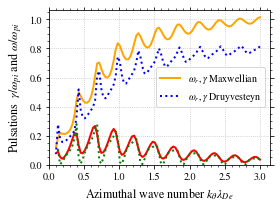

In [26]:
# plot
fig = plt.figure(figsize=(4,3))
plt.plot(kysref, xsref[:,0], "orange", label="$\omega_r, \\gamma$ Maxwellian")
plt.plot(kysref, xsref[:,1], "red")

plt.plot(kysPIC, xsPIC[:,0], "b:", label="$\omega_r, \\gamma$ Druyvesteyn")
plt.plot(kysPIC, xsPIC[:,1], "g:")


plt.legend()
plt.xlabel("Azimuthal wave number $k_{\\theta}\\lambda_{De}$")
plt.ylabel("Pulsations  $\\gamma/\\omega_{pi}$ and $ \\omega/\\omega_{pi} $")
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()
plt.savefig("ECDI_druv.pdf")

/home/tavant/bin/MyVenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


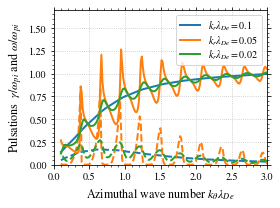

In [32]:
# Compute
kx = 0.05
kz = 0.0
prt=PlasmaParameters(ti = 0.1, te=50)

plasmaEps = partial(eps_ECDI, Zlocal=plasma_dispersion_func, prt=prt, Nmax = 20)
wrfunct = lambda k: analytic_IAW(k, ti=prt.ti/ prt.te)



fig = plt.figure(figsize=(4,3))
lines=[]
for kx in [0.1, 0.02, 0.05]:
    kysref, xsref = solvekys(plasmaEps, kx=kx, kz=kz, kymin=3, kymax=0.1, Nkys=200, wrfunct=wrfunct, method="lm")
    line, = plt.plot(kysref, xsref[:,0])
    plt.plot(kysref, xsref[:,1], c=line.get_color(), linestyle="--")
    
    lines.append(line)
    

plt.ylim(bottom=0, top = 1.7)
plt.legend(lines, [f"$k_r \\lambda_{{De}}= {kx} $" for kx in [0.1, 0.05, 0.02] ], labelspacing=0.1)

plt.xlabel("Azimuthal wave number $k_{\\theta}\\lambda_{De}$")
plt.ylabel("Pulsations  $\\gamma/\\omega_{pi}$ and $ \\omega/\\omega_{pi} $")
plt.xlim(left=0, right=3)

plt.tight_layout()
plt.savefig("ECDI_ktheta_impact.pdf")